In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

import torch.utils

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from random import randint

In [ ]:
device = torch.device("cuda")
#device = torch.device("cpu")
print(device)

cuda


In [ ]:
path = "/content/drive/My Drive/cv_project/"

In [ ]:
x_train = np.load(path+'/x_train.npy')
y_train = np.load(path+'/y_train.npy')
x_val = np.load(path+'/x_val.npy')
y_val = np.load(path+'/y_val.npy')

In [ ]:
x_train.shape

(14952, 1, 48, 48)

In [ ]:
size = 224
transform = transforms.Compose(
    [#transforms.ToPILImage(),
     transforms.RandomResizedCrop(size),
     transforms.Grayscale(num_output_channels=3),
     transforms.RandomRotation(degrees = 10),
     transforms.RandomHorizontalFlip(),
     #transforms.RandomVerticalFlip(),
     transforms.ToTensor(),
     # mean and std when vgg16 is trained
     #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
     transforms.Normalize([0.449, 0.449, 0.449], [0.226, 0.226, 0.226])
])

class MyDataset(Dataset):
    def __init__(self, data, target, transform=transform):
        self.data = torch.from_numpy(data).float()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
     
    def __len__(self):
        return len(self.target)
    
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        a = x.numpy()
        b = np.squeeze(a, axis=0)
        c = Image.fromarray((b * 255).astype(np.uint8)) # Convert to PILImage
        d = self.transform(c)
        
        return d, y

In [ ]:
batchsize_train = 100
batchsize_val = 6
in_channel = 1
num_classes = 16
learning_rate = 0.006
num_epochs = 40

In [ ]:
train_dataset = MyDataset(x_train, y_train)
train_loader = DataLoader(dataset=train_dataset, batch_size=batchsize_train, shuffle=True)

#val_dataset = MyDataset(x_val, y_val)
#val_loader = DataLoader(dataset=val_dataset, batch_size=batchsize, shuffle=True)


In [ ]:
val_dataset = MyDataset(x_val, y_val)
val_loader = DataLoader(dataset=val_dataset, batch_size=batchsize_val, shuffle=True)

In [ ]:
len(train_loader)

150

In [ ]:
for x,y in train_loader:
  print('ok')
  break

ok


In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
for param in model_ft.parameters():
    param.requires_grad = True
model_ft.fc = nn.Sequential(
                            nn.Linear(num_ftrs, 256),
                            nn.ReLU(),
                            nn.Dropout(0.4),
                            nn.Linear(256, 64),
                            nn.ReLU(),
                            nn.Dropout(0.4),
                            nn.Linear(64, num_classes)
                            )


model_ft = model_ft.to(device)


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.SGD(model_ft.parameters(), lr=0.04)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)

In [ ]:
losses=[]
accuracy=[]
for epoch in range(40):
    running_loss=0.0
    running_acc=0
    model_ft.train()
    half_len = len(train_loader)
    for (data, targets) in train_loader:
        
        optimizer.zero_grad()

        targets = targets.long()
        data = data.to(device)
        targets = targets.to(device)

        scores = model_ft(data)
        
        loss = criterion(scores, targets)
        
        loss.backward()
        optimizer.step()

        _, predictions = torch.max(scores, 1)

        running_loss += loss.detach().item()*data.size(0)
        running_acc += torch.sum(predictions == targets.data)
        #print(predictions)
        #print(targets.data)

    exp_lr_scheduler.step()
    epoch_loss = running_loss/len(train_dataset)
    losses.append(epoch_loss)
    epoch_acc = running_acc.item()/len(train_dataset)
    accuracy.append(epoch_acc)
    print('Epoch {} : loss = {}  accuracy = {}'.format(epoch,epoch_loss,epoch_acc))

Epoch 0 : loss = 2.371168973230308  accuracy = 0.25608614232209737
Epoch 1 : loss = 2.0035952625585915  accuracy = 0.37847779561262707
Epoch 2 : loss = 1.7622790571328086  accuracy = 0.4344569288389513
Epoch 3 : loss = 1.6332890029703633  accuracy = 0.46201177100053503
Epoch 4 : loss = 1.5345439317393519  accuracy = 0.49043606206527557
Epoch 5 : loss = 1.492410165699744  accuracy = 0.4954521134296415
Epoch 6 : loss = 1.4595780386651755  accuracy = 0.5010700909577314
Epoch 7 : loss = 1.4377764143237077  accuracy = 0.5088282504012841
Epoch 8 : loss = 1.3944614705011256  accuracy = 0.5214018191546281
Epoch 9 : loss = 1.3716637194953927  accuracy = 0.526083467094703
Epoch 10 : loss = 1.3678945590621843  accuracy = 0.5250802568218299
Epoch 11 : loss = 1.3416630529094469  accuracy = 0.532035848047084
Epoch 12 : loss = 1.3321976651476946  accuracy = 0.5353798822899947
Epoch 13 : loss = 1.3210217004921936  accuracy = 0.5409978598180846
Epoch 14 : loss = 1.3177314548010237  accuracy = 0.5385901

Text(0.5, 0, 'No. of epochs')

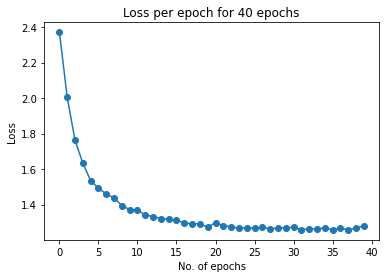

In [ ]:
plt.plot(losses,'-o')
plt.title('Loss per epoch for 40 epochs')
plt.ylabel('Loss')
plt.xlabel('No. of epochs')

Text(0.5, 0, 'No. of epochs')

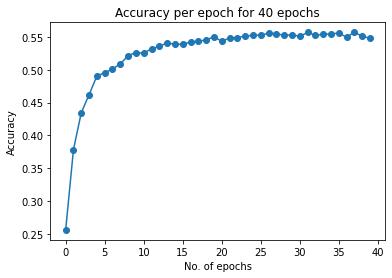

In [ ]:
plt.plot(accuracy,'-o')
plt.title('Accuracy per epoch for 40 epochs')
plt.ylabel('Accuracy')
plt.xlabel('No. of epochs')

In [ ]:

running_loss=0.0
running_acc=0
model_ft.eval()
for (data, targets) in val_loader:

  targets = targets.long()
  data = data.to(device)
  targets = targets.to(device)

  scores = model_ft(data)
        
  loss = criterion(scores, targets)
        

  _, predictions = torch.max(scores, 1)

  running_loss += loss.detach().item()*data.size(0)
  running_acc += torch.sum(predictions == targets.data)

epoch_loss = running_loss/len(val_dataset)
epoch_acc = running_acc.item()/len(val_dataset)
print('Validation : loss = {}  accuracy = {}'.format(epoch_loss,epoch_acc))

Validation : loss = 1.262696742043168  accuracy = 0.5601684717208183
